In [1]:
import re
import os
import nltk
import string
import pickle
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

## General function used in project

In [2]:

def create_dataframe(path):
    
    """
    Creating a dataframe of the text file.
    
    Args:
        path: Path in which the text file exists.
        
    Return:
        df: Text file extracted in the dataframe for further computations.
    """
    
    content = []
    file_names = []

    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r') as file:
            content.append(file.read())
            file_names.append(filename)

    df = pd.DataFrame({'Filename': file_names, 'Content': content})
    return df

#########################################################################################

"""
    Preprocessing the text dataset which is acquired.
    
    Args:
        df: Dataframe of whose preprocessing is to be done for a particular column.
        column: Column name for which preprocessing is to be done.
        
    Return:
        df: Preprocessed dataframe
"""
def preprocess_text(df, column):
    
    # Remove special characters and numbers
    df[column] = df[column].apply(lambda text: re.sub(r'[^a-zA-Z\s]', '', str(text)))
    
    # Convert to lowercase
    df[column] = df[column].str.lower()
    
    # Remove multiple occurrences of 'i' characters
    df[column] = df[column].apply(lambda text: re.sub(r'(i{2,})', 'i', str(text)))
    
    # Remove single alphabets
    df[column] = df[column].apply(lambda text: re.sub(r'\b[a-zA-Z]\b', '', str(text)))
    
    # Tokenize the text
    df[column] = df[column].apply(lambda text: nltk.word_tokenize(text))
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    df[column] = df[column].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    df[column] = df[column].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
    
    # Remove 'mmddyyy'
    df[column] = df[column].apply(lambda text: re.sub(r'(\b[mmddyyy]+\b)', '', str(text)))
    
    # Remove extra whitespace
    df[column] = df[column].apply(lambda text: re.sub(r'\s+', '', str(text)))
    
    # Join the tokens back into a string
    df[column] = df[column].apply(lambda tokens: ''.join(tokens))
    
    return df

#########################################################################################

"""
    Calculate TF-IDF vectorization between train and test dataset.
    
    Args:
        train: Train dataframe.
        test: Test dataframe-
        column_train: Column of intrest from the training dataframe.
        column_test: Column of intrest from the testing dataframe.
        
    
    Returns:
        train: Array-like or sparse matrix representing the training vectors.
        test: Array-like or sparse matrix representing the test vectors.

"""

def tfidf(train, column_train, test, column_test):
    
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    
    # Fit the vectorizer on the training documents
    train = vectorizer.fit_transform(train[column_train])

    # Apply the same vectorizer on the test documents
    test = vectorizer.transform(test[column_test])

    print(train.shape)
    print(test.shape)
    return train, test

#########################################################################################

def calculate_cosine_similarity(train, test):
    """
    Calculate cosine similarity between two sets of vectors.
    
    Args:
        train: Array-like or sparse matrix representing the training vectors.
        test: Array-like or sparse matrix representing the test vectors.
    
    Returns:
        cos_sim: Array representing the cosine similarity between the training and test vectors.
    """
    cos_sim = cosine_similarity(train, test)
    return cos_sim

#########################################################################################

#------------Data visualization--------------------#

"""
Plotting Heatmap and Histogram form better data visualization.

Args:
    argument: Array cosine similarity between training and testing vectors.
"""

def heatmapvis(argument):
    # Create a heatmap plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(argument, cmap='cool')
    plt.title('Cosine Similarity')
    plt.xlabel('Test Documents')
    plt.ylabel('Train Documents')
    plt.show()

def histogramvis(argument):
    plt.hist(argument.flatten(), bins=20)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Cosine Similarity')
    plt.show()
    
#########################################################################################

"""
    Calculate top 10 document which is most similar according to Cosine similarity.
    
    Args:
        cosinesimilarity: Array-like cosine similarity between training and testing vectors.
    
    Return:
        top_similarities: Document number which is most similar in both the data.
"""

def top10(cosinesimilarity):
    
    doc_index = 0  # Index of the document to find similarities for
    N = 10  # Number of top similarities to retrieve
    top_similarities = sorted(range(len(cosinesimilarity[doc_index])), key=lambda i: cosinesimilarity[doc_index][i], reverse=True)[:N]
    return top_similarities

#########################################################################################

"""
    Calculate pecentile 25th, 50th and 75th percentile to find distribution of the dataset w.r.t cosine similarity of 
    TF-IDF vectorization.
    
    Args:
        cosinesimilarity: Array-like cosine similarity between training and testing vectors.
"""

def percentile(cosinesimilarity):
    
    percentiles = np.percentile(cosinesimilarity, [10, 50, 75])


    print("10th percentile:", percentiles[0]*100)
    print("50th percentile:", percentiles[1]*100)
    print("75th percentile:", percentiles[2]*100)

#########################################################################################  

"""
    Calculate the Word2Vec of dataset  
    
    Args:
        df: Name of the dataframe who comparision is tobe done with train dataset.
        column: Column name for which vectorization is to be done with training dataset.
    
    Return:
        similarity_matrix_name: Array like similarity between trian and chossen dataset.
"""

def word2vec(df,column):
    
    # Train Word2Vec model
    model = gensim.models.Word2Vec(df[column], vector_size=100, window=5, min_count=1, workers=4)
    return model

## Train Dataset

In [3]:
df_train = create_dataframe("/mnt/c/Users/alamm9/Desktop/text_file_train_test/train_set")

In [4]:
#df_train

In [5]:
df_train = preprocess_text(df_train, "Content")

In [6]:
#df_train["Content"][0]

## In_sample Dataset

In [7]:
df_in_test = create_dataframe("/mnt/c/Users/alamm9/Desktop/text_file_train_test/In_sample_test")

In [8]:
df_in_test = preprocess_text(df_in_test, "Content")

## Out_of_sample Dataset

In [9]:
df_out_test = create_dataframe("/mnt/c/Users/alamm9/Desktop/text_file_train_test/Out_of_sample_test")

In [10]:
df_out_test = preprocess_text(df_out_test, "Content")

## Foreign Dataset

In [11]:
df_foreign = pd.read_csv("/mnt/c/Users/alamm9/Desktop/text_file_train_test/fake.csv")

In [12]:
#df_foreign.head()

In [13]:
selected_text = df_foreign['text'].sample(n=500, random_state=42)

# Create a new DataFrame with the selected text
selected_df = pd.DataFrame(selected_text, columns=['text'])

In [14]:
selected_df = preprocess_text(selected_df,"text")

In [15]:
# selected_df

In [16]:
selected_df.shape

(500, 1)

## Calculating TF-IDF on Train and In_Sample, Out_of_Sample & Foregin Dataset

In [17]:
 # Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
    
# Fit the vectorizer on the training documents
train = vectorizer.fit_transform(df_train["Content"])

# Apply the same vectorizer on the test documents
test = vectorizer.transform(df_in_test["Content"])

cos1 = calculate_cosine_similarity(train, test)
mean_similarity_In_Sample = np.mean(cos1, axis=1)

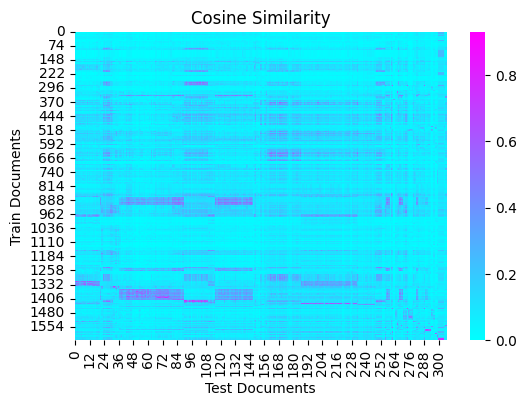

In [18]:
heatmapvis(cos1)

In [19]:
top10(cos1)

[304, 300, 302, 301, 303, 282, 138, 19, 241, 79]

In [20]:
 # Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
    
# Fit the vectorizer on the training documents
train = vectorizer.fit_transform(df_train["Content"])

# Apply the same vectorizer on the test documents
test = vectorizer.transform(df_out_test["Content"])

cos2= calculate_cosine_similarity(train, test)
mean_similarity_Out_Of_Sample = np.mean(cos2, axis=1)

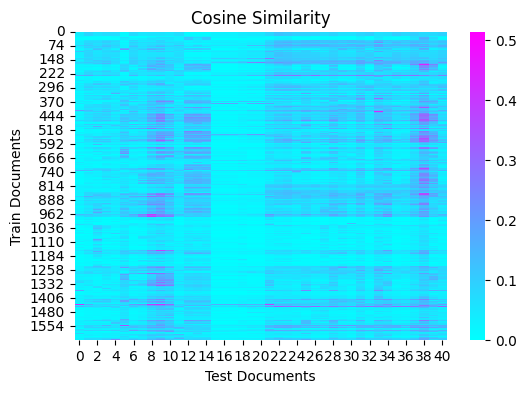

In [21]:
heatmapvis(cos2)

In [22]:
top10(cos2)

[22, 23, 35, 32, 37, 24, 25, 26, 40, 28]

In [23]:
 # Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
    
# Fit the vectorizer on the training documents
train = vectorizer.fit_transform(df_train["Content"])

# Apply the same vectorizer on the test documents
test = vectorizer.transform(selected_df["text"])

cos3 = calculate_cosine_similarity(train, test)
mean_similarity_foreign = np.mean(cos3, axis=1)

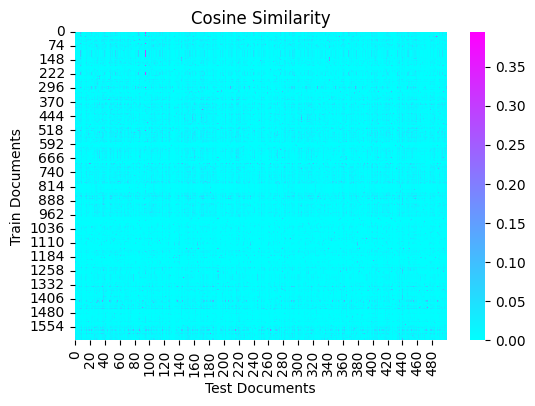

In [24]:
heatmapvis(cos3)

In [25]:
top10(cos3)

[95, 7, 85, 54, 368, 234, 240, 22, 433, 494]

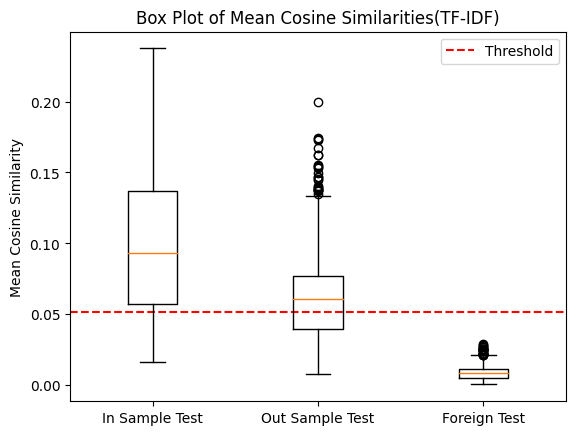

In [26]:
# Load the saved threshold
with open("threshold(tfidf).pkl", "rb") as f:
    threshold = pickle.load(f)# Create a grouped box plot
data = [mean_similarity_In_Sample, mean_similarity_Out_Of_Sample, mean_similarity_foreign]
labels = ['In Sample Test', 'Out Sample Test', 'Foreign Test']
# Add a dashed line for the threshold
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.boxplot(data, labels=labels)
plt.title("Box Plot of Mean Cosine Similarities(TF-IDF)")
plt.ylabel("Mean Cosine Similarity")
plt.legend()
plt.show()

In [27]:
# Train Word2Vec model
model = gensim.models.Word2Vec(df_train["Content"], vector_size=100, window=5, min_count=1, workers=4)

# Obtain document embeddings for the training set
train_embeddings = [np.mean([model.wv[token] for token in doc_tokens if token in model.wv], axis=0) for doc_tokens in df_train["Content"]]
    
# Transform the test set embeddings using the learned transformation from the training set
test_embeddings = [np.mean([model.wv[token] for token in doc_tokens if token in model.wv], axis=0) for doc_tokens in df_in_test["Content"]]

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(train_embeddings, test_embeddings) 
print("similarity_matrix",similarity_matrix.shape)
# Calculate mean similarity for each row
mean_similarity_In_Sample = np.mean(similarity_matrix, axis=1)

similarity_matrix (1626, 307)


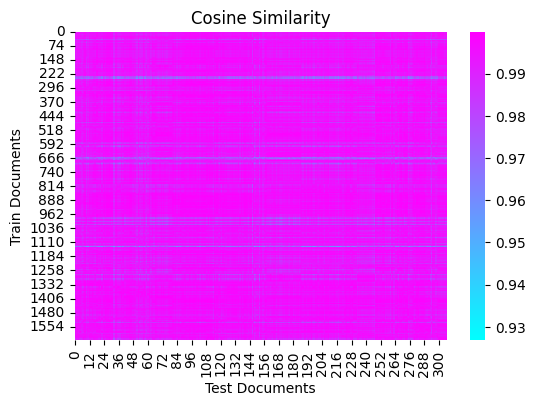

In [28]:
heatmapvis(similarity_matrix)

In [29]:
top10(similarity_matrix )

[110, 18, 295, 153, 296, 8, 95, 145, 254, 282]

In [30]:
# Train Word2Vec model
model = gensim.models.Word2Vec(df_train["Content"], vector_size=100, window=5, min_count=1, workers=4)

# Obtain document embeddings for the training set
train_embeddings = [np.mean([model.wv[token] for token in doc_tokens if token in model.wv], axis=0) for doc_tokens in df_train["Content"]]
    
# Transform the test set embeddings using the learned transformation from the training set
test_embeddings = [np.mean([model.wv[token] for token in doc_tokens if token in model.wv], axis=0) for doc_tokens in df_out_test["Content"]]

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(train_embeddings, test_embeddings) 
print("similarity_matrix",similarity_matrix.shape)
# Calculate mean similarity for each row
mean_similarity_Out_Of_Sample = np.mean(similarity_matrix, axis=1)

similarity_matrix (1626, 41)


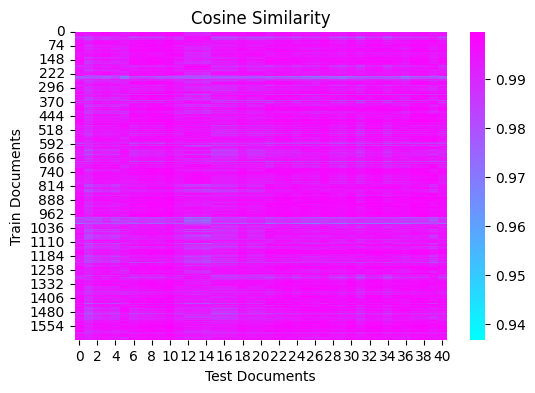

In [31]:
heatmapvis(similarity_matrix)

In [32]:
top10(similarity_matrix )

[11, 3, 7, 10, 20, 19, 18, 23, 17, 16]

In [33]:
# Train Word2Vec model
model = gensim.models.Word2Vec(df_train["Content"], vector_size=100, window=5, min_count=1, workers=4)

# Obtain document embeddings for the training set
train_embeddings = [np.mean([model.wv[token] for token in doc_tokens if token in model.wv], axis=0) for doc_tokens in df_train["Content"]]
    
# Transform the test set embeddings using the learned transformation from the training set
test_embeddings = [np.mean([model.wv[token] for token in doc_tokens if token in model.wv], axis=0) for doc_tokens in selected_df["text"]]

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(train_embeddings, test_embeddings) 
print("similarity_matrix",similarity_matrix.shape)
# Calculate mean similarity for each row
mean_similarity_foreign = np.mean(similarity_matrix, axis=1)

similarity_matrix (1626, 500)


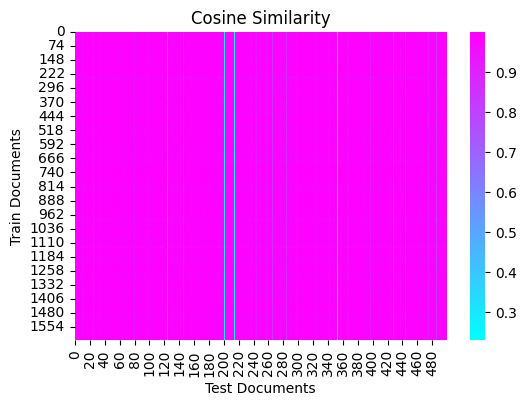

In [34]:
heatmapvis(similarity_matrix)

In [35]:
top10(similarity_matrix )

[128, 126, 311, 287, 393, 309, 155, 433, 242, 139]

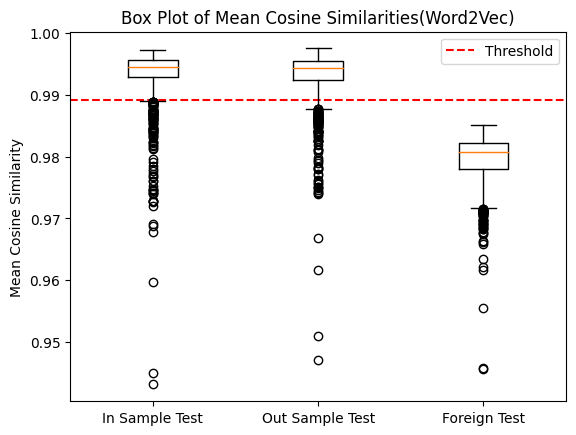

In [37]:
# Load the saved threshold
with open("threshold(w2v).pkl", "rb") as f:
    threshold = pickle.load(f)

data = [mean_similarity_In_Sample, mean_similarity_Out_Of_Sample, mean_similarity_foreign]
labels = ['In Sample Test', 'Out Sample Test', 'Foreign Test']
# Add a dashed line for the threshold
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.boxplot(data, labels=labels)
plt.title("Box Plot of Mean Cosine Similarities(Word2Vec)")
plt.ylabel("Mean Cosine Similarity")
plt.legend()
plt.show()